In [1]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

jungang_col = keti_db.jungang_pattern
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [49]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 100

def compile_and_fit(model, window, EPOCHS = 20,patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[
                    tf.metrics.MeanAbsoluteError(),
                    
                ])

  history = model.fit(window.train, epochs=EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [50]:
jungang_db_cur = jungang_col.find()
db_datas = [_ for _ in jungang_db_cur]

jg_datas = pd.DataFrame(columns=['Date Time','energy (kw 15min)'])
jg_datas['Date Time'] = [_['ttime'] for _ in db_datas]
jg_datas['energy (kw 15min)'] = [_['energy'] for _ in db_datas]

date_time = pd.to_datetime(jg_datas.pop('Date Time'),
                          format="%Y-%m-%d %H:%M:%S")
jg_datas.index = date_time


# 불 필요 데이터 잘라내기
idx = jg_datas.index.get_loc(jg_datas[jg_datas['energy (kw 15min)'] == 0].index[7])

jg_datas = jg_datas.iloc[:idx].copy()
jg_datas

,energy (kw 15min)
Date Time,
2017-01-01 00:00:00,15250
2017-01-01 00:15:00,15250
2017-01-01 00:30:00,13750
2017-01-01 00:45:00,14250
2017-01-01 01:00:00,14000
...,...
2018-09-19 22:45:00,18750
2018-09-19 23:00:00,18250
2018-09-19 23:15:00,18000


In [51]:
def calc_sin(ts, target_value):
    return np.sin(ts * (2 * np.pi / target_value)).values
def calc_cos(ts, target_value):
    return np.cos(ts * (2 * np.pi / target_value)).values
def get_season(month):
    if month in [3,4,5]:
        return "봄"
    elif month in [6,7,8]:
        return "여름"
    elif month in [9,10,11]:
        return "가을"
    else:
        return "겨울"
def get_season_to_idx(season):
    if season == "봄":
        return 1
    elif season == "여름":
        return 2
    elif season == "가을":
        return 3
    elif season == "겨울":
        return 4
    
def get_weather_to_idx(weather):
    if weather == "특이사항없음":
        return 1
    elif weather == "비":
        return 2
    elif weather == "눈":
        return 3

# ~ 2018 year data parsing
jg_datas = jg_datas[jg_datas.index.year <= 2018]
date_time = jg_datas.index
timestamp = date_time.map(dt.timestamp)

day = 24 * 60 * 60
week = 7 * day
year = (365) * day

jg_datas['week sin'] = calc_sin(timestamp, week)
jg_datas['week cos'] = calc_cos(timestamp, week)
jg_datas['year sin'] = calc_sin(timestamp, year)
jg_datas['year cos'] = calc_cos(timestamp, year)
jg_datas['season'] = [get_season(_.month) for _ in jg_datas.index]
jg_datas['season idx'] = [get_season_to_idx(_) for _ in jg_datas['season'].values]

jg_datas = jg_datas[::4]
jg_datas

,energy (kw 15min),week sin,week cos,year sin,year cos,season,season idx
Date Time,,,,,,,
2017-01-01 00:00:00,15250,0.707107,-0.707107,0.198782,0.980044,겨울,4
2017-01-01 01:00:00,14000,0.680173,-0.733052,0.199485,0.979901,겨울,4
2017-01-01 02:00:00,14750,0.652287,-0.757972,0.200188,0.979758,겨울,4
2017-01-01 03:00:00,29500,0.623490,-0.781831,0.200891,0.979614,겨울,4
2017-01-01 04:00:00,15750,0.593820,-0.804598,0.201593,0.979469,겨울,4
...,...,...,...,...,...,...,...
2018-09-19 19:00:00,22500,-0.500000,0.866025,-0.999984,-0.005738,가을,3
2018-09-19 20:00:00,19250,-0.467269,0.884115,-0.999987,-0.005021,가을,3
2018-09-19 21:00:00,20250,-0.433884,0.900969,-0.999991,-0.004304,가을,3


In [54]:
# 날씨 데이터 가져오기
weather_df = pd.DataFrame(columns=['weather','avg ta', 'avg rhm'])
for weather in weather_col.find():
    try:
        iscs = weather['weather']
    except:
        iscs = "특이사항없음"
    if iscs != "특이사항없음":
        iscs_idx = 0
        for hours in range(0, 24):
            if (iscs[iscs_idx]['end time'] == ""):
                iscs[iscs_idx]['end time'] = weather['date'].replace(hour=23)
            if (hours >= iscs[iscs_idx]['start time'].hour) and \
                (hours <= iscs[iscs_idx]['end time'].hour):
                weather_df = weather_df.append({
                    "weather": iscs[iscs_idx]['weather'],
                    "avg ta": weather['avgTa'],
                    "avg rhm": weather['avgRhm']
                }, ignore_index=True)
            else:
                weather_df = weather_df.append({
                    "weather": "특이사항없음",
                    "avg ta": weather['avgTa'],
                    "avg rhm": weather['avgRhm']
                }, ignore_index=True)
            
            if ((iscs_idx + 1) < len(iscs)) and \
                (iscs[iscs_idx]['end time'].hour < (hours + 1)):
                iscs_idx += 1
    else:
        for hours in range(0, 24):
            weather_df = weather_df.append({
                "weather": "특이사항없음",
                "avg ta": weather['avgTa'],
                "avg rhm": weather['avgRhm']
            }, ignore_index=True)    
        
all_data_length = len(jg_datas)
jg_datas['weather'] = list(weather_df['weather'].values)[:all_data_length]
jg_datas['weather idx'] = list(get_weather_to_idx(_) for _ in weather_df['weather'].values)[:all_data_length]
jg_datas['avg ta'] = list(map(float,weather_df['avg ta'].values))[:all_data_length]
jg_datas['avg rhm'] = list(map(float,weather_df['avg rhm'].values))[:all_data_length]

jg_datas

,energy (kw 15min),week sin,week cos,year sin,year cos,season,season idx,weather,weather idx,avg ta,avg rhm
Date Time,,,,,,,,,,,
2017-01-01 00:00:00,15250,0.707107,-0.707107,0.198782,0.980044,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 01:00:00,14000,0.680173,-0.733052,0.199485,0.979901,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 02:00:00,14750,0.652287,-0.757972,0.200188,0.979758,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 03:00:00,29500,0.623490,-0.781831,0.200891,0.979614,겨울,4,특이사항없음,1,2.7,75.9
2017-01-01 04:00:00,15750,0.593820,-0.804598,0.201593,0.979469,겨울,4,특이사항없음,1,2.7,75.9
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-19 19:00:00,22500,-0.500000,0.866025,-0.999984,-0.005738,가을,3,비,2,22.1,59.1
2018-09-19 20:00:00,19250,-0.467269,0.884115,-0.999987,-0.005021,가을,3,비,2,22.1,59.1
2018-09-19 21:00:00,20250,-0.433884,0.900969,-0.999991,-0.004304,가을,3,비,2,22.1,59.1


In [7]:
all_dict = dict()
train_type = ['univariate', 
              'multivariate', 
#               'season univariate', 
#               'season multivariate', 
              'multivariate (ta-rhm)', 
              'multivariate (week)', 
              'multivariate (season)',              
              'multivariate (week-season)',              
              'with cluster label',
              'with cluster label (multivariate)',
              'with cluster label (multivariate-ta-rhm)',
              'with cluster label (multivariate-week)',
              'with cluster label (multivariate-season)',
              'with cluster label (multivariate-week-season)'              
             ]
uni_columns = ['energy (kw 15min)']
mul_week_columns = ['energy (kw 15min)', 'week sin', 'week cos']
mul_only_season_columns = ['energy (kw 15min)', 'season idx']
mul_season_columns = ['energy (kw 15min)', 'week sin', 'week cos', 'season idx']
mul_ta_rhm_columns = ['energy (kw 15min)', 'avg ta', 'avg rhm'] 
mul_columns = ['energy (kw 15min)', 'week sin', 'week cos', 'year sin', 'year cos', 'season idx', 'avg ta', 'avg rhm']
seasons = ["봄", "여름", "가을", "겨울"]

# Clusterinbg 가져오기 작업
cur_cluster_result = cluster_col.find({
    "uid": "jungang_pattern"
})
cluster_result = dict()

for data in cur_cluster_result:
    in_dict = pd.DataFrame(columns=['Label', 'Weekday'])
    in_dict.index.name = "Date Time"
    
    season = data['season']
    infos = data['info']
    
    dtime = [dt.strptime(_['date'], "%Y-%m-%d") for _ in infos]
    labels = [_['label'] for _ in infos]

    for idx, _ in enumerate(dtime):
        label = labels[idx]        
        in_dict.loc[_] = [label, _.weekday()]
        
    cluster_result[season] = in_dict
    
cluster_pattern_dict = dict()

for season in seasons:
    result = cluster_result[season]
    in_dict = pd.DataFrame(columns=[_ for _ in range(0, 24)])
    in_dict.index.name = "Label"
    
    labels = list(set(result['Label']))
    for label in labels:
        cluster_pattern = np.array([])
        date_in_labels = result[result['Label'] == label].index
        for date in date_in_labels:
            idx = jg_datas.index.get_loc(date)
            pattern = jg_datas.iloc[idx: idx+24]['energy (kw 15min)'].values
            cluster_pattern = np.append(cluster_pattern, pattern)
        cluster_pattern = cluster_pattern.reshape(-1,24).mean(axis=0)
        in_dict.loc[label] = cluster_pattern
        
    cluster_pattern_dict[season] = in_dict
    
# Clustering Matching
cluster_dist_dict = dict()
for season in cluster_result.keys():
    cluster_season_dict = dict()
    week_list = set(cluster_result[season]['Weekday'])
    for week in week_list:
        week_dist = cluster_result[season][
            cluster_result[season]['Weekday'] == week
        ]['Weekday'].groupby(cluster_result[season]['Label']).count().sort_values(ascending=False)
        week_top_label = week_dist.index[0]
        
        cluster_season_dict[week] = week_top_label
    cluster_dist_dict[season] = cluster_season_dict

In [8]:
cluster_pattern_col = pd.DataFrame(columns=['cluster energy'])
for idx in range(0, len(jg_datas), 24):
    datas = jg_datas.iloc[idx: idx + 24].copy()
    date = datas.index[0]
    
    season = get_season(date.month)
    weekday = date.weekday()
    label = cluster_dist_dict[season][weekday]
    c_pattern = cluster_pattern_dict[season].loc[label].values
    
    for idx, _ in enumerate(datas.index):
        cluster_pattern_col.loc[_] = c_pattern[idx]
        
cluster_pattern_col

,cluster energy
2017-01-01 00:00:00,18390.625000
2017-01-01 01:00:00,17125.000000
2017-01-01 02:00:00,16265.625000
2017-01-01 03:00:00,22843.750000
2017-01-01 04:00:00,19328.125000
...,...
2018-09-19 19:00:00,19027.777778
2018-09-19 20:00:00,13638.888889
2018-09-19 21:00:00,11486.111111
2018-09-19 22:00:00,10638.888889


In [35]:
day_1_size = 24
year_half_size = day_1_size * int(365 / 4) 
year_1_size = day_1_size * 365

is_switch = True

training_datas = jg_datas[:year_1_size]
validation_datas = jg_datas[year_1_size:
                        year_1_size + year_half_size]
testing_datas = jg_datas[year_1_size + year_half_size:]
if is_switch == True:
    tmp = validation_datas.copy()
    validation_datas = testing_datas.copy()
    testing_datas = tmp

In [36]:
for t_type in train_type:
    if 'week-season' in t_type:
        in_dict = dict()
        in_col = mul_season_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
#     if 'season' in t_type:
#         seasons_dict = dict()
#         for season in seasons:
#             season_dict = dict()
#             in_col = mul_columns if "multivariate" in t_type else uni_columns
            
#             season_dict['train'] = training_datas[in_col][training_datas['season'] == season].copy()
#             season_dict['val'] = validation_datas[in_col].copy()
#             season_dict['test'] = testing_datas[in_col].copy()
            
#             seasons_dict[season] = season_dict
#         all_dict[t_type] = seasons_dict
    elif 'season' in t_type:
        in_dict = dict()
        in_col = mul_only_season_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    elif 'week' in t_type:
        in_dict = dict()
        in_col = mul_week_columns
#         in_col = uni_columns if "univariate" in t_type else mul_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    elif 'ta-rhm' in t_type:
        in_dict = dict()
        in_col = mul_ta_rhm_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict
    else:
        in_dict = dict()
        in_col = mul_columns if "multivariate" in t_type else uni_columns
#         in_col = uni_columns if "univariate" in t_type else mul_columns
        
        in_dict['train'] = training_datas[in_col].copy()
        in_dict['val'] = validation_datas[in_col].copy()
        in_dict['test'] = testing_datas[in_col].copy()
        
        all_dict[t_type] = in_dict

In [37]:
norm_all_dict = dict()

mean = training_datas.mean()
std = training_datas.std()

for key in all_dict.keys():
#     in_col = mul_week_columns if "week" in key else mul_season_columns if "season" in key else mul_columns if "multivariate" in key else uni_columns
#     in_col = uni_columns if "univariate" in key else mul_columns
    
    in_col = None
    
    if "week-season" in key:
        in_col = mul_season_columns
    elif "season" in key:
        in_col = mul_only_season_columns
    elif "week" in key:
        in_col = mul_week_columns
    elif "ta-rhm" in key:
        in_col = mul_ta_rhm_columns
    elif "multivariate" in key:
        in_col = mul_columns
    else:
        in_col = uni_columns
        
    in_dict = all_dict[key].copy()
    print(mean[in_col])
    m = mean[in_col]
    s = std[in_col]

    train = in_dict['train'].copy()
    val = in_dict['val'].copy()
    test = in_dict['test'].copy()

    in_dict['train'] = (train - m) / s
    in_dict['val'] = (val - m) / s
    in_dict['test'] = (test - m) / s
#     if "season" in key:
#         for season in seasons:
#             train = in_dict[season]['train'].copy()
#             val = in_dict[season]['val'].copy()
#             test = in_dict[season]['test'].copy()
            
#             in_dict[season]['train'] = (train - m) / s
#             in_dict[season]['val'] = (val - m) / s
#             in_dict[season]['test'] = (test - m) / s
#     else:
#         train = in_dict['train'].copy()
#         val = in_dict['val'].copy()
#         test = in_dict['test'].copy()
        
#         in_dict['train'] = (train - m) / s
#         in_dict['val'] = (val - m) / s
#         in_dict['test'] = (test - m) / s
        
    norm_all_dict[key] = in_dict

energy (kw 15min)    25051.997717
dtype: float64
energy (kw 15min)    2.505200e+04
week sin             9.214506e-04
week cos            -2.483390e-03
year sin            -2.603796e-16
year cos            -4.312380e-16
season idx           2.490411e+00
avg ta               1.307315e+01
avg rhm              5.772849e+01
dtype: float64
energy (kw 15min)    25051.997717
avg ta                  13.073151
avg rhm                 57.728493
dtype: float64
energy (kw 15min)    25051.997717
week sin                 0.000921
week cos                -0.002483
dtype: float64
energy (kw 15min)    25051.997717
season idx               2.490411
dtype: float64
energy (kw 15min)    25051.997717
week sin                 0.000921
week cos                -0.002483
season idx               2.490411
dtype: float64
energy (kw 15min)    25051.997717
dtype: float64
energy (kw 15min)    2.505200e+04
week sin             9.214506e-04
week cos            -2.483390e-03
year sin            -2.603796e-16
year cos   

In [38]:
# Cluster Energy Norm
for key in norm_all_dict.keys():
    if "with cluster" in key:
        mean = all_dict[key]['train'].mean().values[0]
        std = all_dict[key]['train'].std().values[0]
        
        norm_cluster_pattern_col = (cluster_pattern_col.copy() - mean) / std
        c_norm_dict = norm_all_dict[key].copy()
        
        for c_key in c_norm_dict.keys():
            c_norm_dict[c_key]['cluster energy'] = norm_cluster_pattern_col['cluster energy']
        
        
        norm_all_dict[key] = c_norm_dict.copy()

In [39]:
windows = dict()

for key in norm_all_dict.keys():
    nad = norm_all_dict[key]
    
#     if "season" in key:
#         seasons_window = dict()
#         for season in seasons:
#             season_window = dict()
#             for WINDOW_WIDTH in range(3, 21):
#                 h_key = "{} hours".format(WINDOW_WIDTH)
#                 season_window[h_key] = WindowGenerator(
#                         input_width=WINDOW_WIDTH,
#                         label_width=1,
#                         shift=1,
#                         label_columns=uni_columns,
#                         train_df=nad[season]['train'],
#                         val_df=nad[season]['val'],
#                         test_df=nad[season]['test']
#                     )
#             seasons_window[season] = season_window
#         windows[key] = seasons_window
#     else:
    window = dict()
    for WINDOW_WIDTH in range(3, 21):
        h_key = "{} hours".format(WINDOW_WIDTH)
        window[h_key] = WindowGenerator(
                    input_width=WINDOW_WIDTH,
                    label_width=1,
                    shift=1,
                    label_columns=uni_columns,
                    train_df=nad['train'],
                    val_df=nad['val'],
                    test_df=nad['test']
                )
    windows[key] = window

In [40]:
val_performance = dict()
performance = dict()
models = dict()

for key in windows.keys():
    window = windows[key]
    
#     if "season" in key:
#         seasons_val_perfor = dict()
#         seasons_perfor = dict()
#         seasons_model = dict()
#         for season in seasons:
#             season_val_perfor = dict()
#             season_perfor = dict()
#             season_model = dict()
#             for WINDOW_WIDTH in range(3, 4):
#                 IPython.display.clear_output()
#                 print("##### {} Training Start #####".format(key))
#                 print("##### Season is {} #####".format(season))
#                 print("##### Hours is {} #####".format(WINDOW_WIDTH))
#                 h_key = "{} hours".format(WINDOW_WIDTH)
#                 cur_window = window[season][h_key]
                
#                 lstm_model = tf.keras.models.Sequential([
#                     # Shape [batch, time, features] => [batch, time, lstm_units]
#                     tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
#                     # Shape => [batch, time, features]
#                     tf.keras.layers.Dense(units=1)
#                 ])
#                 compile_and_fit(lstm_model, cur_window)
                
#                 season_val_perfor[h_key] = lstm_model.evaluate(
#                     cur_window.val
#                 )
                
#                 season_perfor[h_key] = lstm_model.evaluate(
#                     cur_window.test
#                 )
                
#                 season_model[h_key] = lstm_model
                
#             seasons_val_perfor[season] = season_val_perfor
#             seasons_perfor[season] = season_perfor
#             seasons_model[season] = season_model
#         val_performance[key] = seasons_val_perfor
#         performance[key] = seasons_perfor
#         models[key] = seasons_model
#     else:
    val_perfor = dict()
    perfor = dict()
    model = dict()

    for WINDOW_WIDTH in range(3, 4):
        IPython.display.clear_output()
        print("##### {} Training Start #####".format(key))
        print("##### Hours is {} #####".format(WINDOW_WIDTH))
        h_key = "{} hours".format(WINDOW_WIDTH)

        num_features = norm_all_dict[key]['train'].shape[1]
        cur_window = window[h_key]

        lstm_model = tf.keras.models.Sequential([
                    # Shape [batch, time, features] => [batch, time, lstm_units]
                    tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
                    # Shape => [batch, time, features]
                    tf.keras.layers.Dense(
                        units=1
                    )
                ])
        compile_and_fit(lstm_model, cur_window, 50)

        val_perfor[h_key] = lstm_model.evaluate(
            cur_window.val
        )

        perfor[h_key] = lstm_model.evaluate(
            cur_window.test
        )

        model[h_key] = lstm_model

    val_performance[key] = val_perfor
    performance[key] = perfor
    models[key] = model

##### with cluster label (multivariate-week-season) Training Start #####
##### Hours is 3 #####
Epoch 1/50
274/274 [==============================] - 2s 4ms/step - loss: 0.4635 - mean_absolute_error: 0.5287 - val_loss: 0.2727 - val_mean_absolute_error: 0.3781
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2502 - mean_absolute_error: 0.3743 - val_loss: 0.2143 - val_mean_absolute_error: 0.3237
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2175 - mean_absolute_error: 0.3430 - val_loss: 0.2047 - val_mean_absolute_error: 0.3105
Epoch 4/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2130 - mean_absolute_error: 0.3375 - val_loss: 0.1998 - val_mean_absolute_error: 0.3045
Epoch 5/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2105 - mean_absolute_error: 0.3346 - val_loss: 0.1961 - val_mean_absolute_error: 0.2996
Epoch 6/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2084 - m

univariate


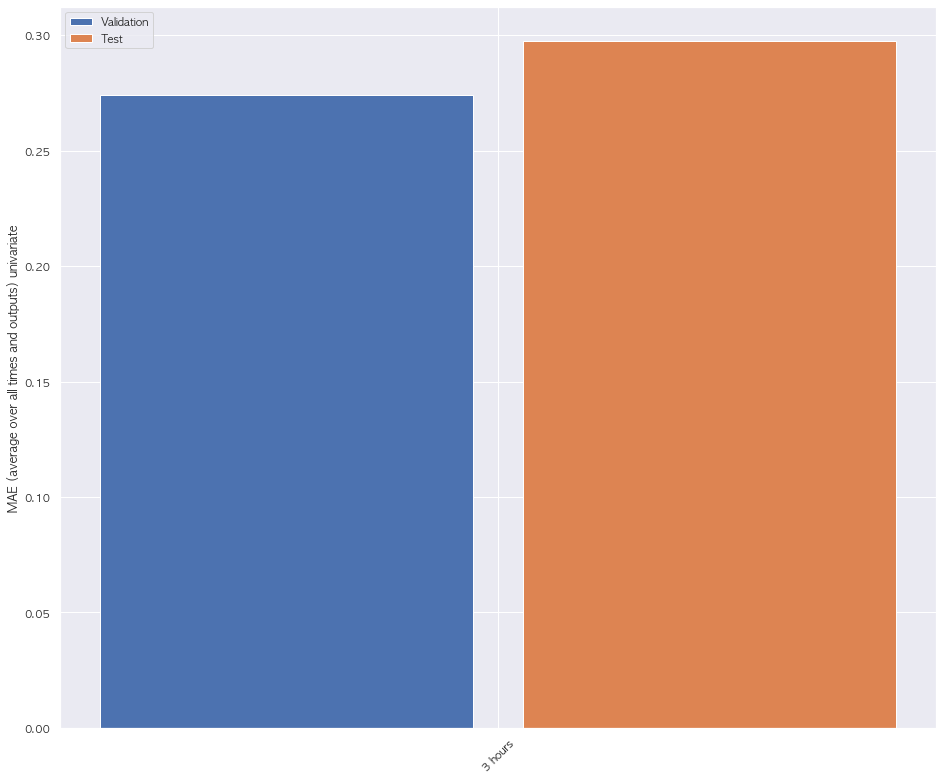

multivariate


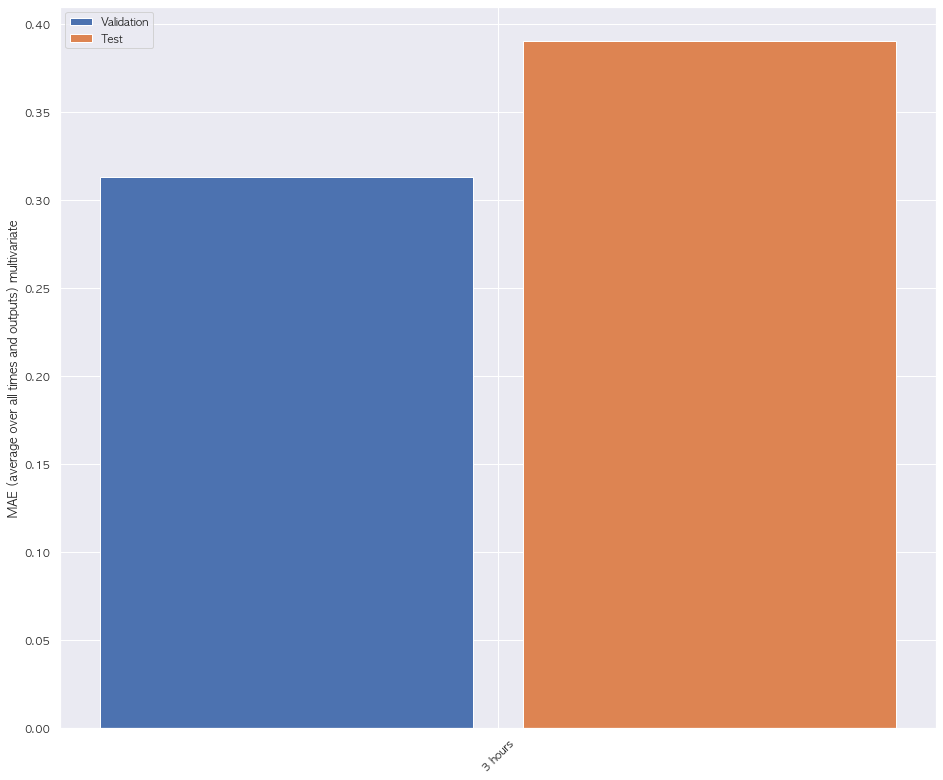

multivariate (ta-rhm)


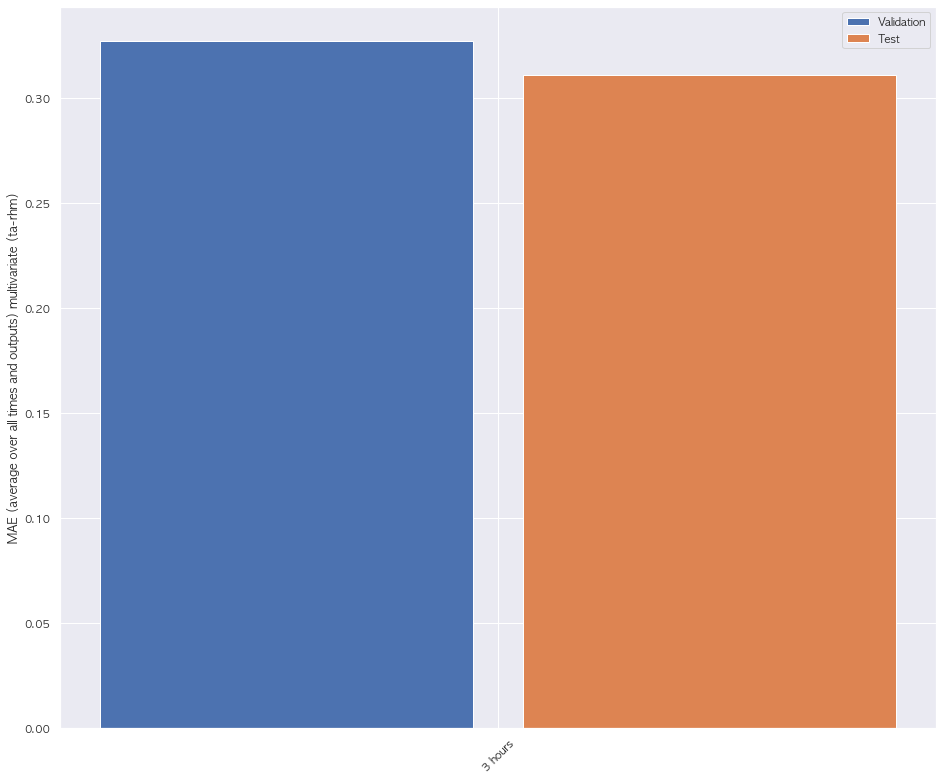

multivariate (week)


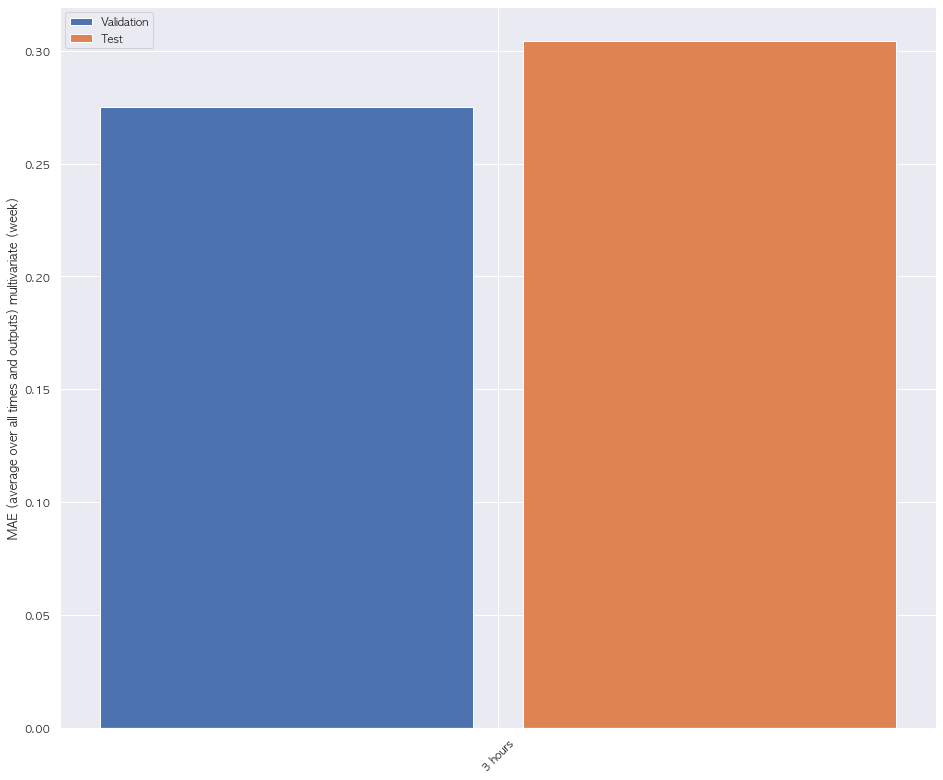

multivariate (season)


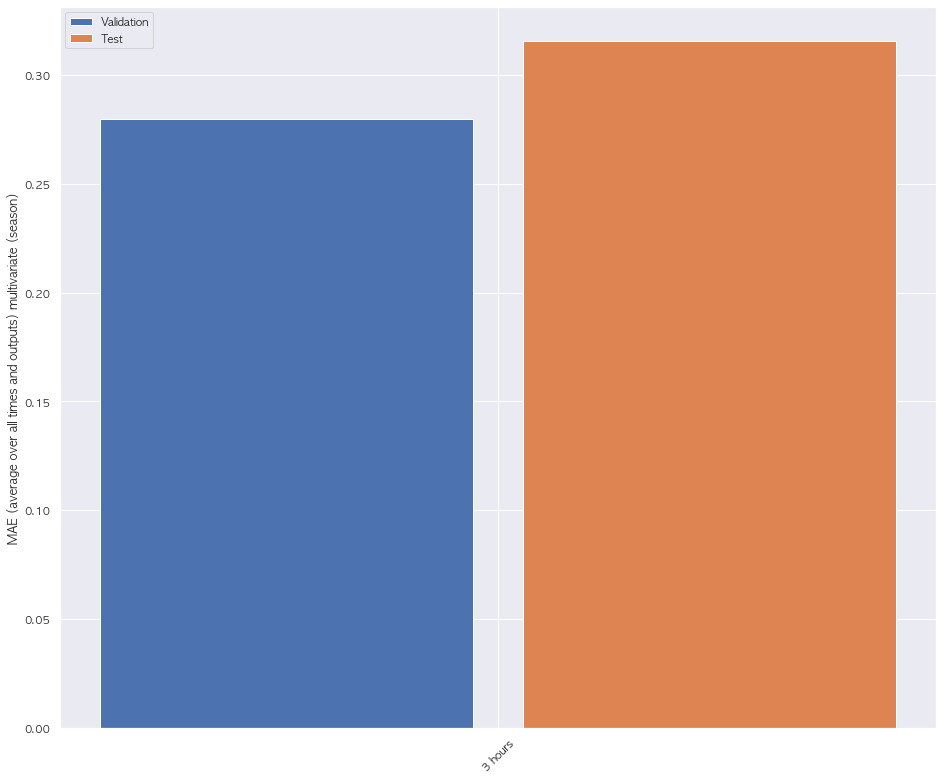

multivariate (week-season)


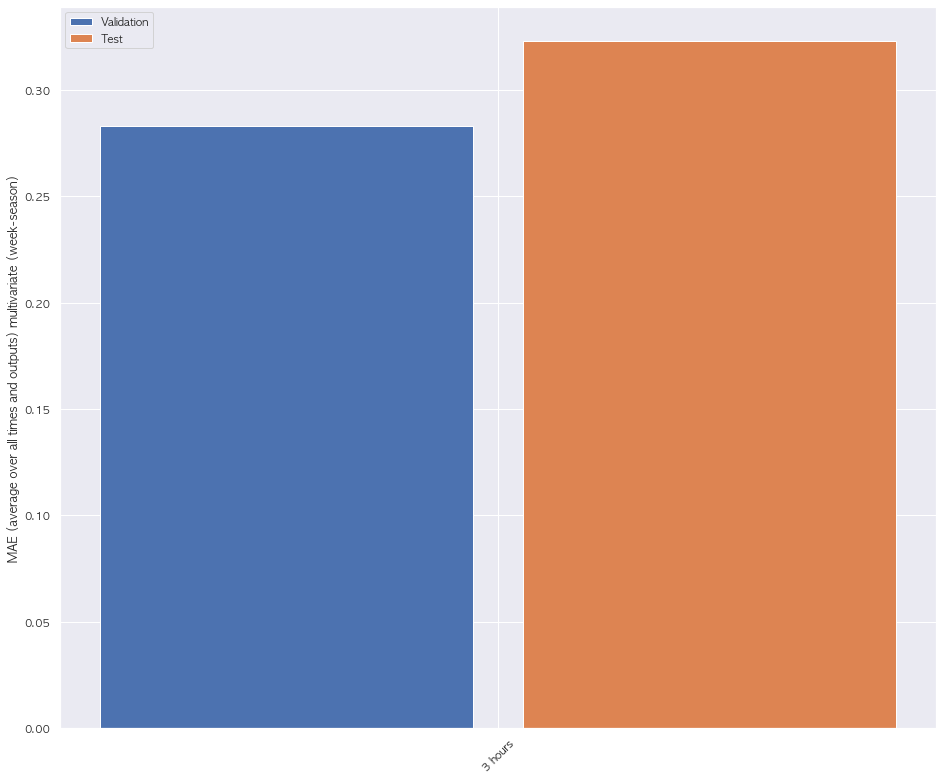

with cluster label


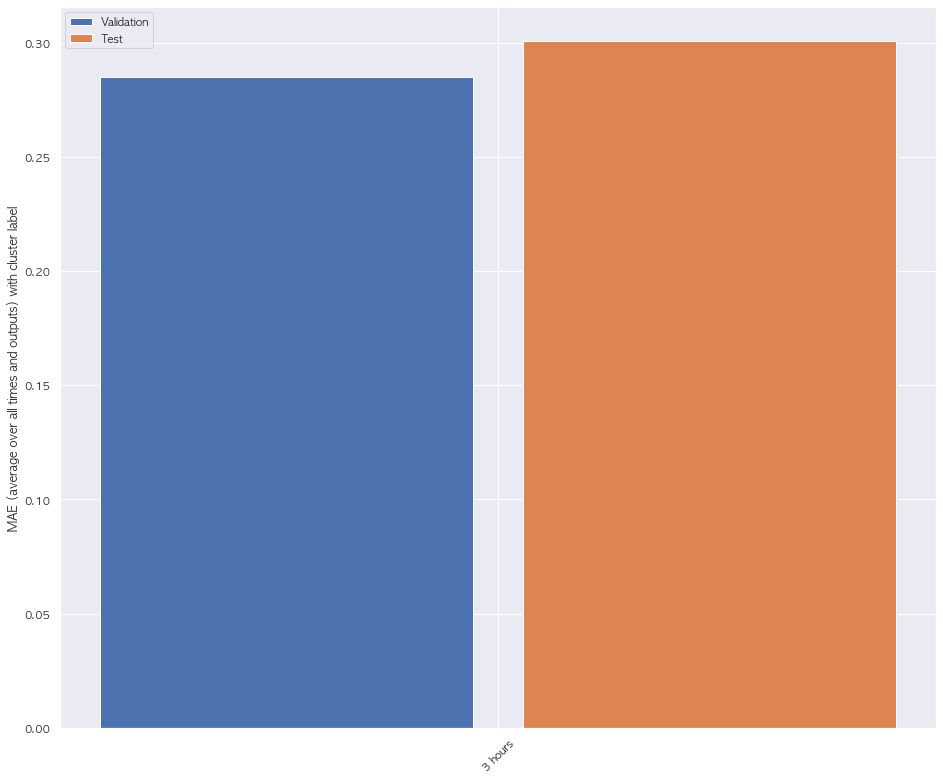

with cluster label (multivariate)


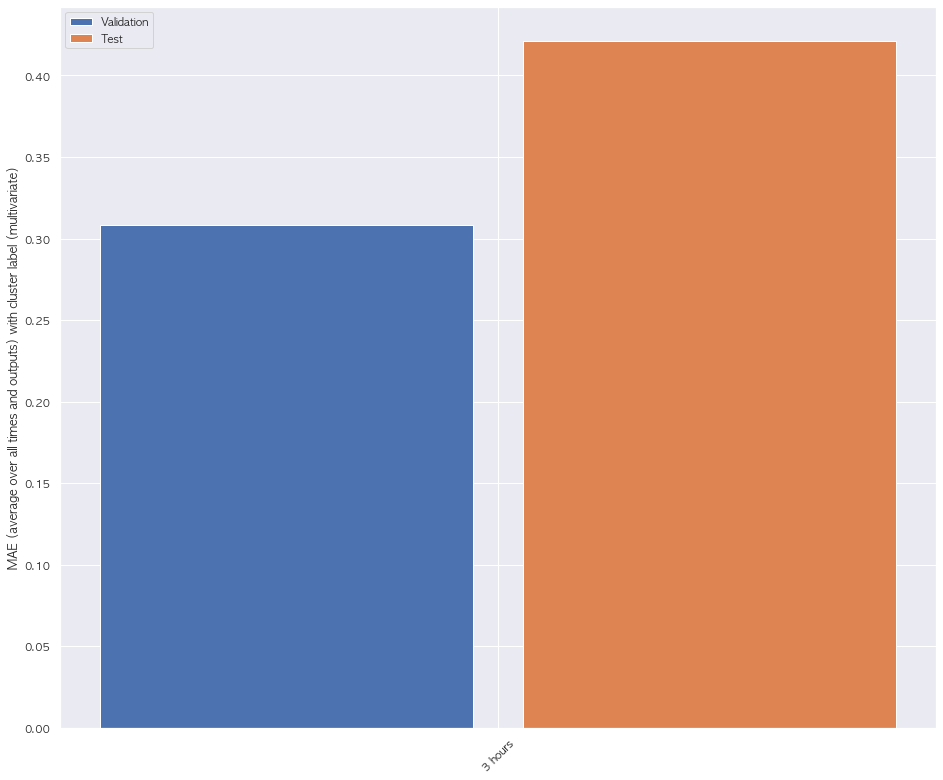

with cluster label (multivariate-ta-rhm)


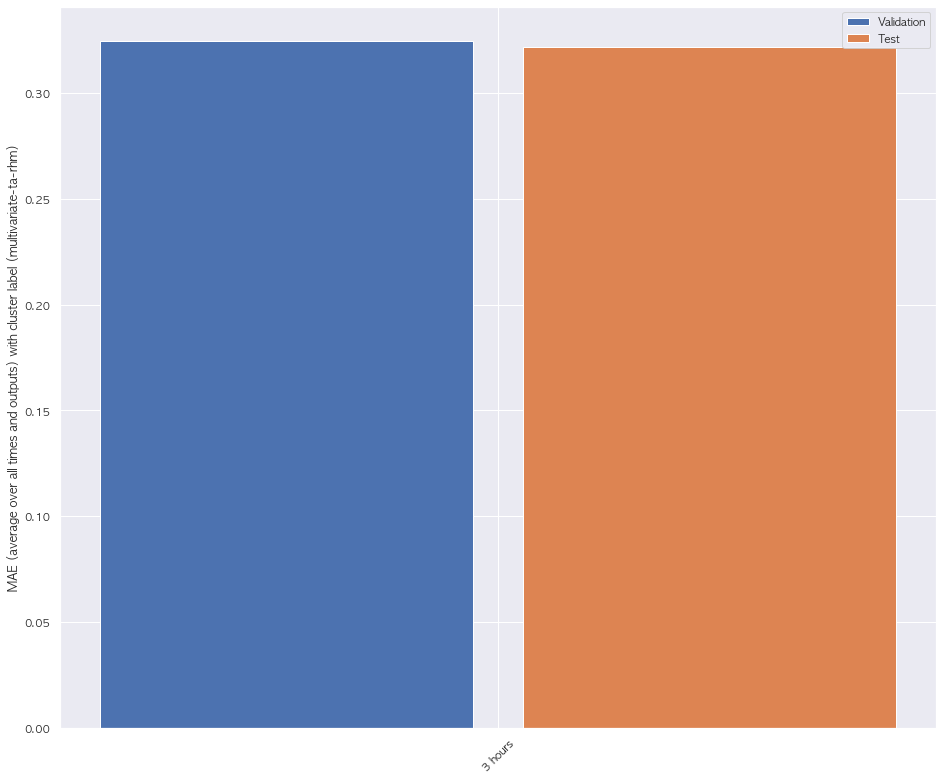

with cluster label (multivariate-week)


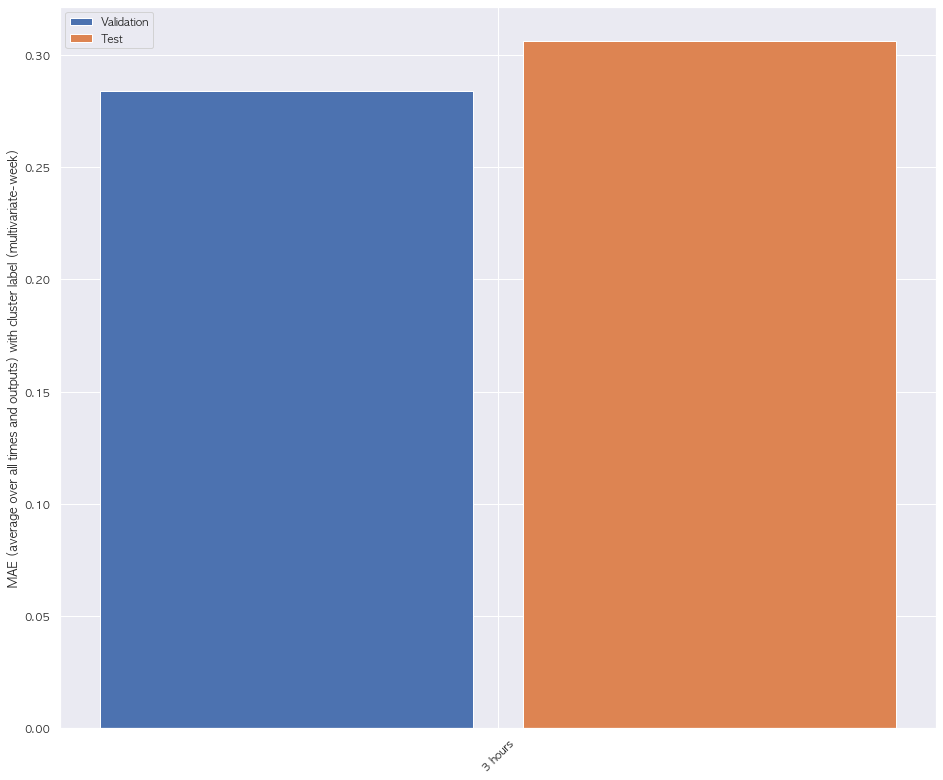

with cluster label (multivariate-season)


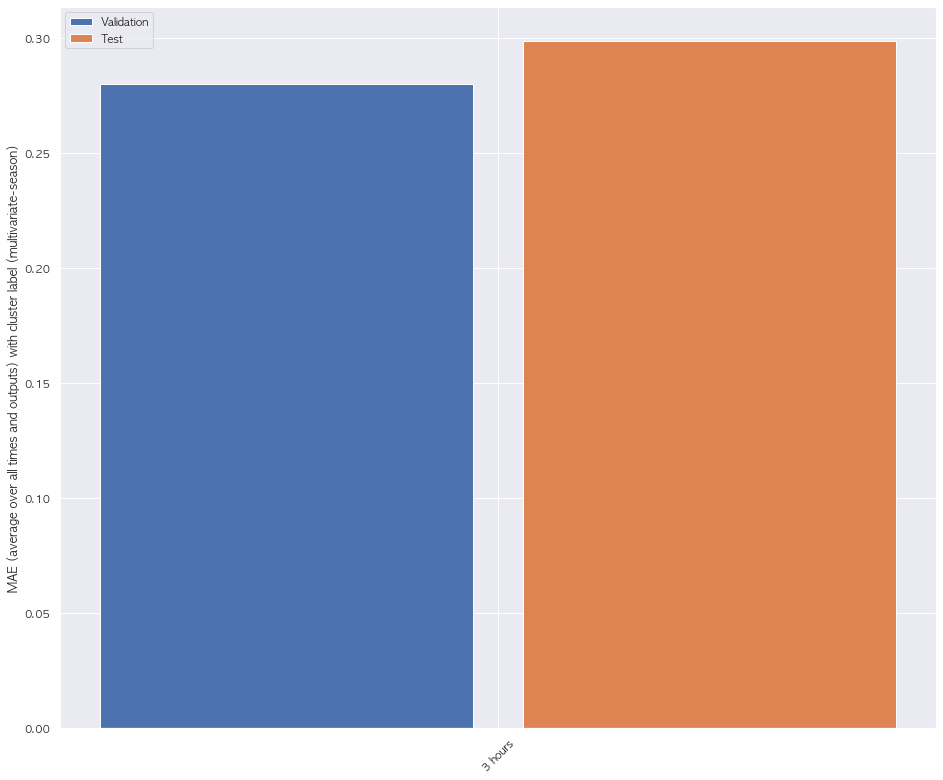

with cluster label (multivariate-week-season)


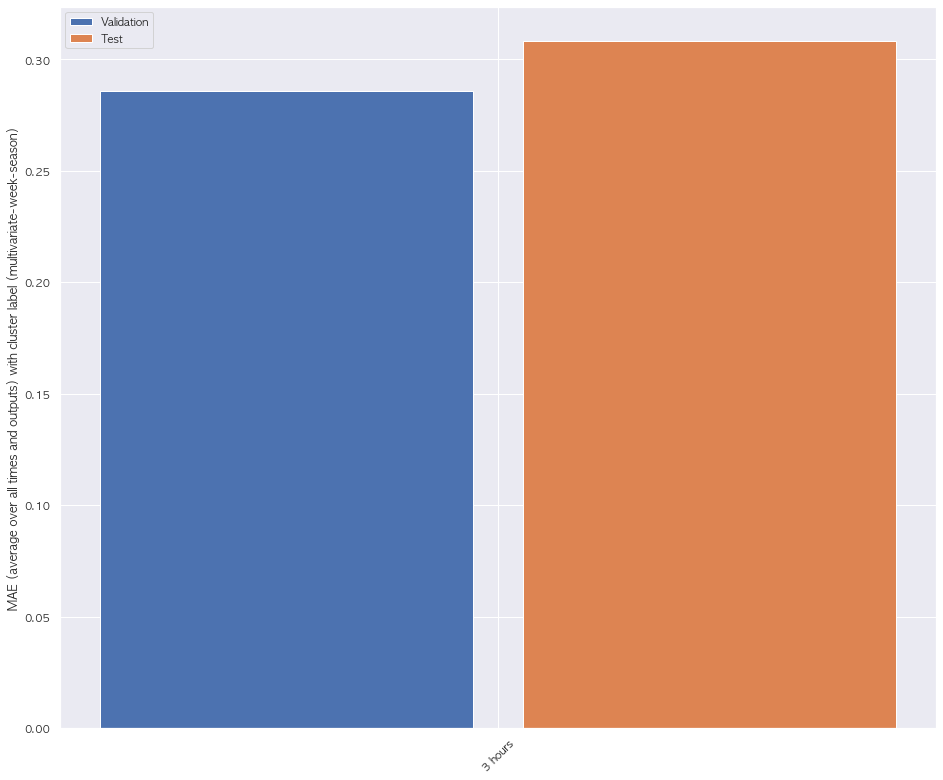

In [41]:
for key in performance.keys():
    print(key)
    cur_val_performance = val_performance[key]
    cur_performance = performance[key]
    
#     if "season" in key:
#         for season in seasons:
#             cur_val_performance = val_performance[key][season]
#             cur_performance = performance[key][season]
            
#             x = np.arange(len(cur_performance))
#             width = 0.3

#             metric_name = 'mean_absolute_error'
#             metric_index = lstm_model.metrics_names.index('mean_absolute_error')
#             val_mae = [v[metric_index] for v in cur_val_performance.values()]
#             test_mae = [v[metric_index] for v in cur_performance.values()]

#             plt.bar(x - 0.17, val_mae, width, label='Validation')
#             plt.bar(x + 0.17, test_mae, width, label='Test')
#             plt.xticks(ticks=x, labels=cur_performance.keys(),
#                        rotation=45)
#             plt.ylabel(f'MAE (average over all times and outputs) {key} {season}')
#             _ = plt.legend()
#             plt.show()
#     else:
    x = np.arange(len(cur_performance))
    width = 0.3

    metric_name = 'mean_absolute_error'
    metric_index = lstm_model.metrics_names.index('mean_absolute_error')
    val_mae = [v[metric_index] for v in cur_val_performance.values()]
    test_mae = [v[metric_index] for v in cur_performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=cur_performance.keys(),
               rotation=45)
    plt.ylabel(f'MAE (average over all times and outputs) {key}')
    _ = plt.legend()
    plt.show()

In [42]:
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

test_df = norm_all_dict['univariate']['test'].copy()
test_df
col_test_df = pd.DataFrame()
for idx in range(0, len(test_df), 24):
    date = test_df.iloc[idx:].index[0]
    col_test_df[date] = test_df.iloc[idx: idx+24]['energy (kw 15min)'].values
mean_pattern = col_test_df.mean(axis=1)

# calc tss, calc wss (only test data)
tss = 0
wss = 0
cluster_distance = np.array([])
cluster_similarity = np.array([])
for idx in range(0, len(test_df), 24):
    date_idxes = test_df[idx: idx+24].index
    
    pattern = test_df.loc[date_idxes]['energy (kw 15min)'].values
    tss += euc(
        mean_pattern[3:],
        pattern[3:]
    ) ** 2
    
    c_pattern = norm_cluster_pattern_col.loc[date_idxes]['cluster energy'].values
    c_distance = euc(
        c_pattern[3:],
        pattern[3:]
    )
    c_similarity = cos_sim(
        c_pattern[3:],
        pattern[3:]
    )
    
    wss += c_distance ** 2
    cluster_distance = np.append(cluster_distance, [c_distance])
    cluster_similarity = np.append(cluster_similarity, [c_similarity])
    
    
cluster_ecv = (1 - (wss / tss)) * 100

evaluate_df = pd.DataFrame(columns=['val_mae','test_mae','ecv', 'mean dis', 'mean sim'])
# evaluate_df.loc['cluster pattern'] = [
#     0,
#     0,
#     cluster_ecv,
#     cluster_distance.mean(),
#     cluster_similarity.mean()
# ]
# evaluate_df

In [43]:
predict_data_length = 3
WINDOW_WIDTH = 3
pattern_dict = None
predict_dict = dict()

for _ in range(0, round(len(norm_all_dict['univariate']['test']) / 24), 50):
    for key in models.keys():
        predict_list = list()
        test_df = norm_all_dict[key]['test'][_ * 24:(_ + 50) * 24]
        feature_length = len(test_df.columns)
        print(_ , key)
        cur_model = models[key]
        cnt = 0

#         if "season" in key:
#             cnt = 0

#             for split in range(0, round(len(test_df)), 24):
#                 h_key = "{} hours".format(WINDOW_WIDTH)

#                 original_x_labels = [idx for idx in range(1,25)]
#                 predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
#                 original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

#                 predicts = []
#                 inputs = []

#                 for idx in range(0, (24 - predict_data_length)):
#                     inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
#                     inputs = inputs.reshape(-1, predict_data_length, feature_length)
#                     result = cur_model[season][h_key](inputs).numpy().flatten()[2]

#                     predicts.append(result)
#                 predict_list.append(predicts)
#                 cnt += 1
#         else:
#         cnt = 0

        for split in range(0, round(len(test_df)), 24):
            h_key = "{} hours".format(WINDOW_WIDTH)

            original_x_labels = [idx for idx in range(1,25)]
            predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
            original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

            predicts = []
            inputs = []

            for idx in range(0, (24 - predict_data_length)):
                inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                inputs = inputs.reshape(-1, predict_data_length, feature_length)
                result = cur_model[h_key](inputs).numpy().flatten()[2]

                predicts.append(result)
            predict_list.append(predicts)
            cnt += 1
        if key not in predict_dict.keys():
            predict_dict[key] = predict_list
        else:
            predict_dict[key] = np.append(predict_dict[key], predict_list)

0 univariate
0 multivariate
0 multivariate (ta-rhm)
0 multivariate (week)
0 multivariate (season)
0 multivariate (week-season)
0 with cluster label
0 with cluster label (multivariate)
0 with cluster label (multivariate-ta-rhm)
0 with cluster label (multivariate-week)
0 with cluster label (multivariate-season)
0 with cluster label (multivariate-week-season)
50 univariate
50 multivariate
50 multivariate (ta-rhm)
50 multivariate (week)
50 multivariate (season)
50 multivariate (week-season)
50 with cluster label
50 with cluster label (multivariate)
50 with cluster label (multivariate-ta-rhm)
50 with cluster label (multivariate-week)
50 with cluster label (multivariate-season)
50 with cluster label (multivariate-week-season)


In [44]:
# predict preprocessing
for key in predict_dict.keys():
    predict_dict[key] = predict_dict[key].reshape(-1,21)
    print(predict_dict[key].shape)

(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)
(91, 21)


In [45]:
test_df = norm_all_dict['univariate']['test'].copy()

for key in predict_dict.keys():
    wss = 0
    distances = np.array([])
    similarities = np.array([])
    og_pattern = np.array([])
    for idx in range(0, len(test_df), 24):
        pattern = test_df.iloc[idx: idx+24]['energy (kw 15min)'].values
        og_pattern = np.append(og_pattern, pattern[3:])
        
        p_idx = round(idx / 24)
        p_pattern = predict_dict[key][p_idx]
        wss += euc(
            p_pattern,
            pattern[3:]
        ) ** 2
        
        distance = euc(
            p_pattern,
            pattern[3:]
        )
        similarity = cos_sim(
            p_pattern,
            pattern[3:]
        )
        
        distances = np.append(distances, [
            distance
        ])
        similarities = np.append(similarities, [
            similarity
        ])
        
    ecv = (1 - (wss / tss)) * 100
    mean_dis = distances.mean()
    mean_sim = similarities.mean()
    
    evaluate_df.loc[key] = [
        val_performance[key]['3 hours'][1],
        performance[key]['3 hours'][1],
        ecv,
        mean_dis,
        mean_sim
    ]

In [46]:
evaluate_df

,val_mae,test_mae,ecv,mean dis,mean sim
univariate,0.274150,0.297533,78.065861,1.305150,0.932487
multivariate,0.313312,0.390575,71.307168,1.562726,0.911248
multivariate (ta-rhm),0.327076,0.310707,74.344473,1.413014,0.920318
multivariate (week),0.275188,0.304347,77.863352,1.307174,0.931934
multivariate (season),0.279561,0.315637,75.523662,1.370979,0.926995
multivariate (week-season),0.282904,0.322969,76.785737,1.349145,0.929602
with cluster label,0.284711,0.300688,79.173783,1.294050,0.937442
with cluster label (multivariate),0.308429,0.421160,67.166280,1.663234,0.906166
with cluster label (multivariate-ta-rhm),0.324571,0.321751,72.990603,1.467541,0.918999
with cluster label (multivariate-week),0.284078,0.306316,79.413124,1.284224,0.938015


In [47]:
predict_one_dict = dict()
for _ in predict_dict.keys():
    predict_one_dict[_] = predict_dict[_].reshape(-1)

In [48]:
evaluate_dict = dict()

for key in predict_dict.keys():
    org_y = og_pattern
    pred_y = predict_one_dict[key]
    
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(org_y, pred_y)
    
    root_mse = tf.keras.metrics.RootMeanSquaredError()
    root_mse.update_state(org_y, pred_y)
    
    msele = tf.keras.metrics.MeanSquaredLogarithmicError()
    msele.update_state(org_y, pred_y)
    
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(org_y, pred_y)
    
    cossim = tf.keras.metrics.CosineSimilarity()
    cossim.update_state(org_y, pred_y)
    
    logcosh = tf.keras.metrics.LogCoshError()
    logcosh.update_state(org_y, pred_y)
    
    print(key)
    print(" mse: {}\n".format(mse.result().numpy()),
         "root_mse: {}\n".format(root_mse.result().numpy()),
         "msele: {}\n".format(msele.result().numpy()),
         "mae: {}\n".format(mae.result().numpy()),
         "cosine similarity: {}\n".format(cossim.result().numpy()),
         "lce: {}\n".format(logcosh.result().numpy()))

univariate
 mse: 0.09555236995220184
 root_mse: 0.309115469455719
 msele: 0.017772013321518898
 mae: 0.19576002657413483
 cosine similarity: 0.9413394331932068
 lce: 0.04218072071671486

multivariate
 mse: 0.12499547004699707
 root_mse: 0.35354697704315186
 msele: 0.01948055438697338
 mae: 0.2731148600578308
 cosine similarity: 0.9255212545394897
 lce: 0.057120393961668015

multivariate (ta-rhm)
 mse: 0.11176394671201706
 root_mse: 0.3343111574649811
 msele: 0.01990126632153988
 mae: 0.21328997611999512
 cosine similarity: 0.9308422803878784
 lce: 0.048952970653772354

multivariate (week)
 mse: 0.09643455594778061
 root_mse: 0.3105391263961792
 msele: 0.018141569569706917
 mae: 0.2062080055475235
 cosine similarity: 0.9406228065490723
 lce: 0.04319093003869057

multivariate (season)
 mse: 0.10662700980901718
 root_mse: 0.3265379071235657
 msele: 0.018554016947746277
 mae: 0.20152269303798676
 cosine similarity: 0.9362770318984985
 lce: 0.04626676067709923

multivariate (week-season)
 m

0 univariate
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py", line 4518, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

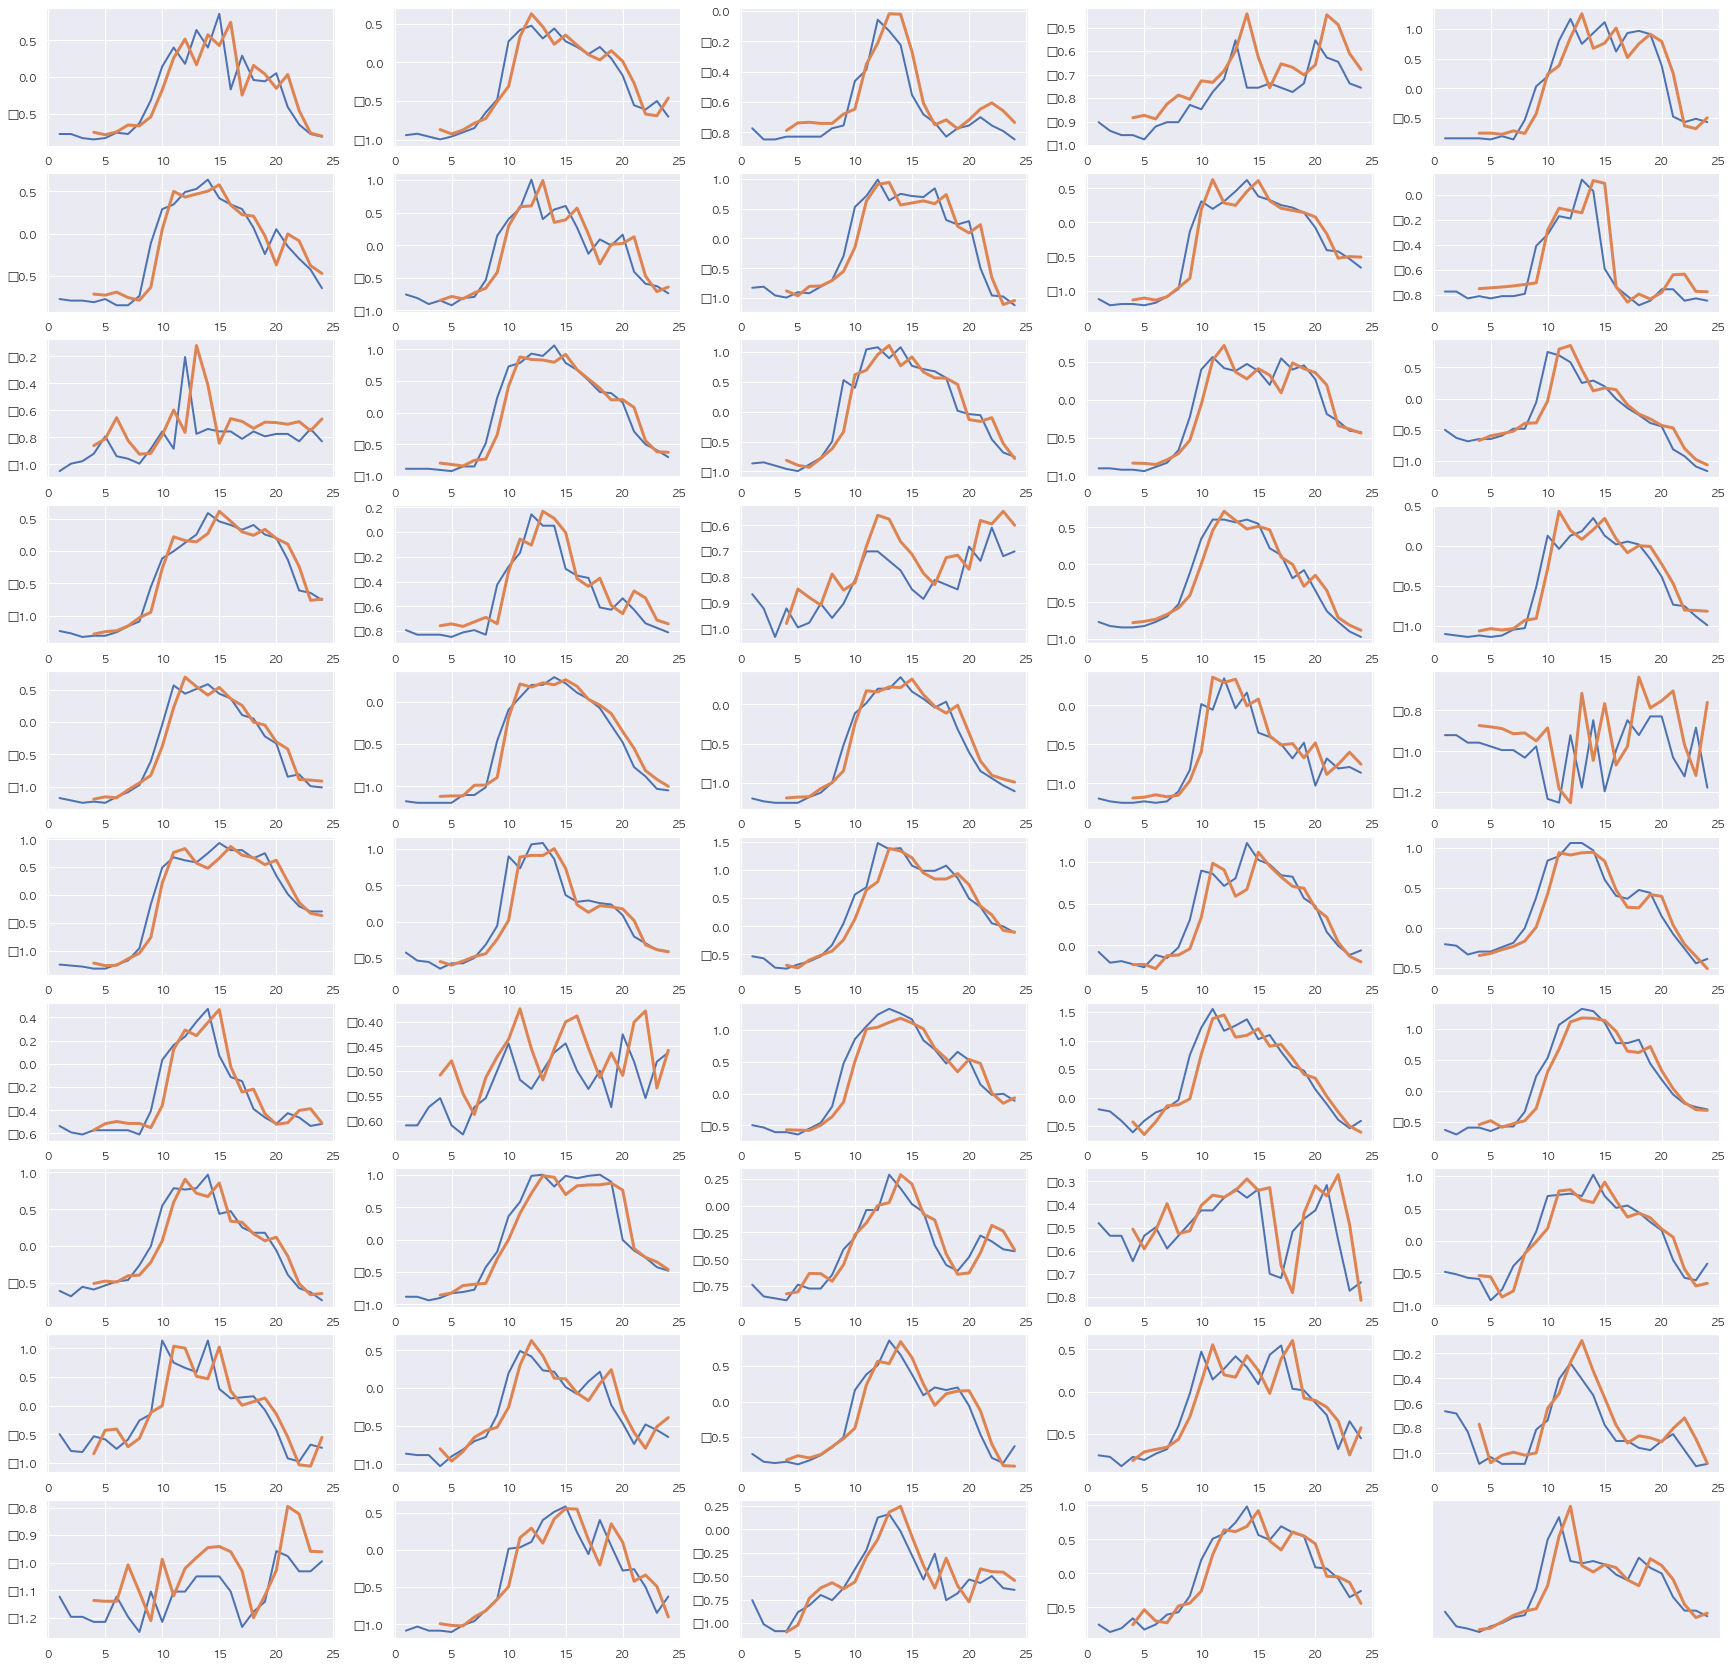

0 multivariate


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


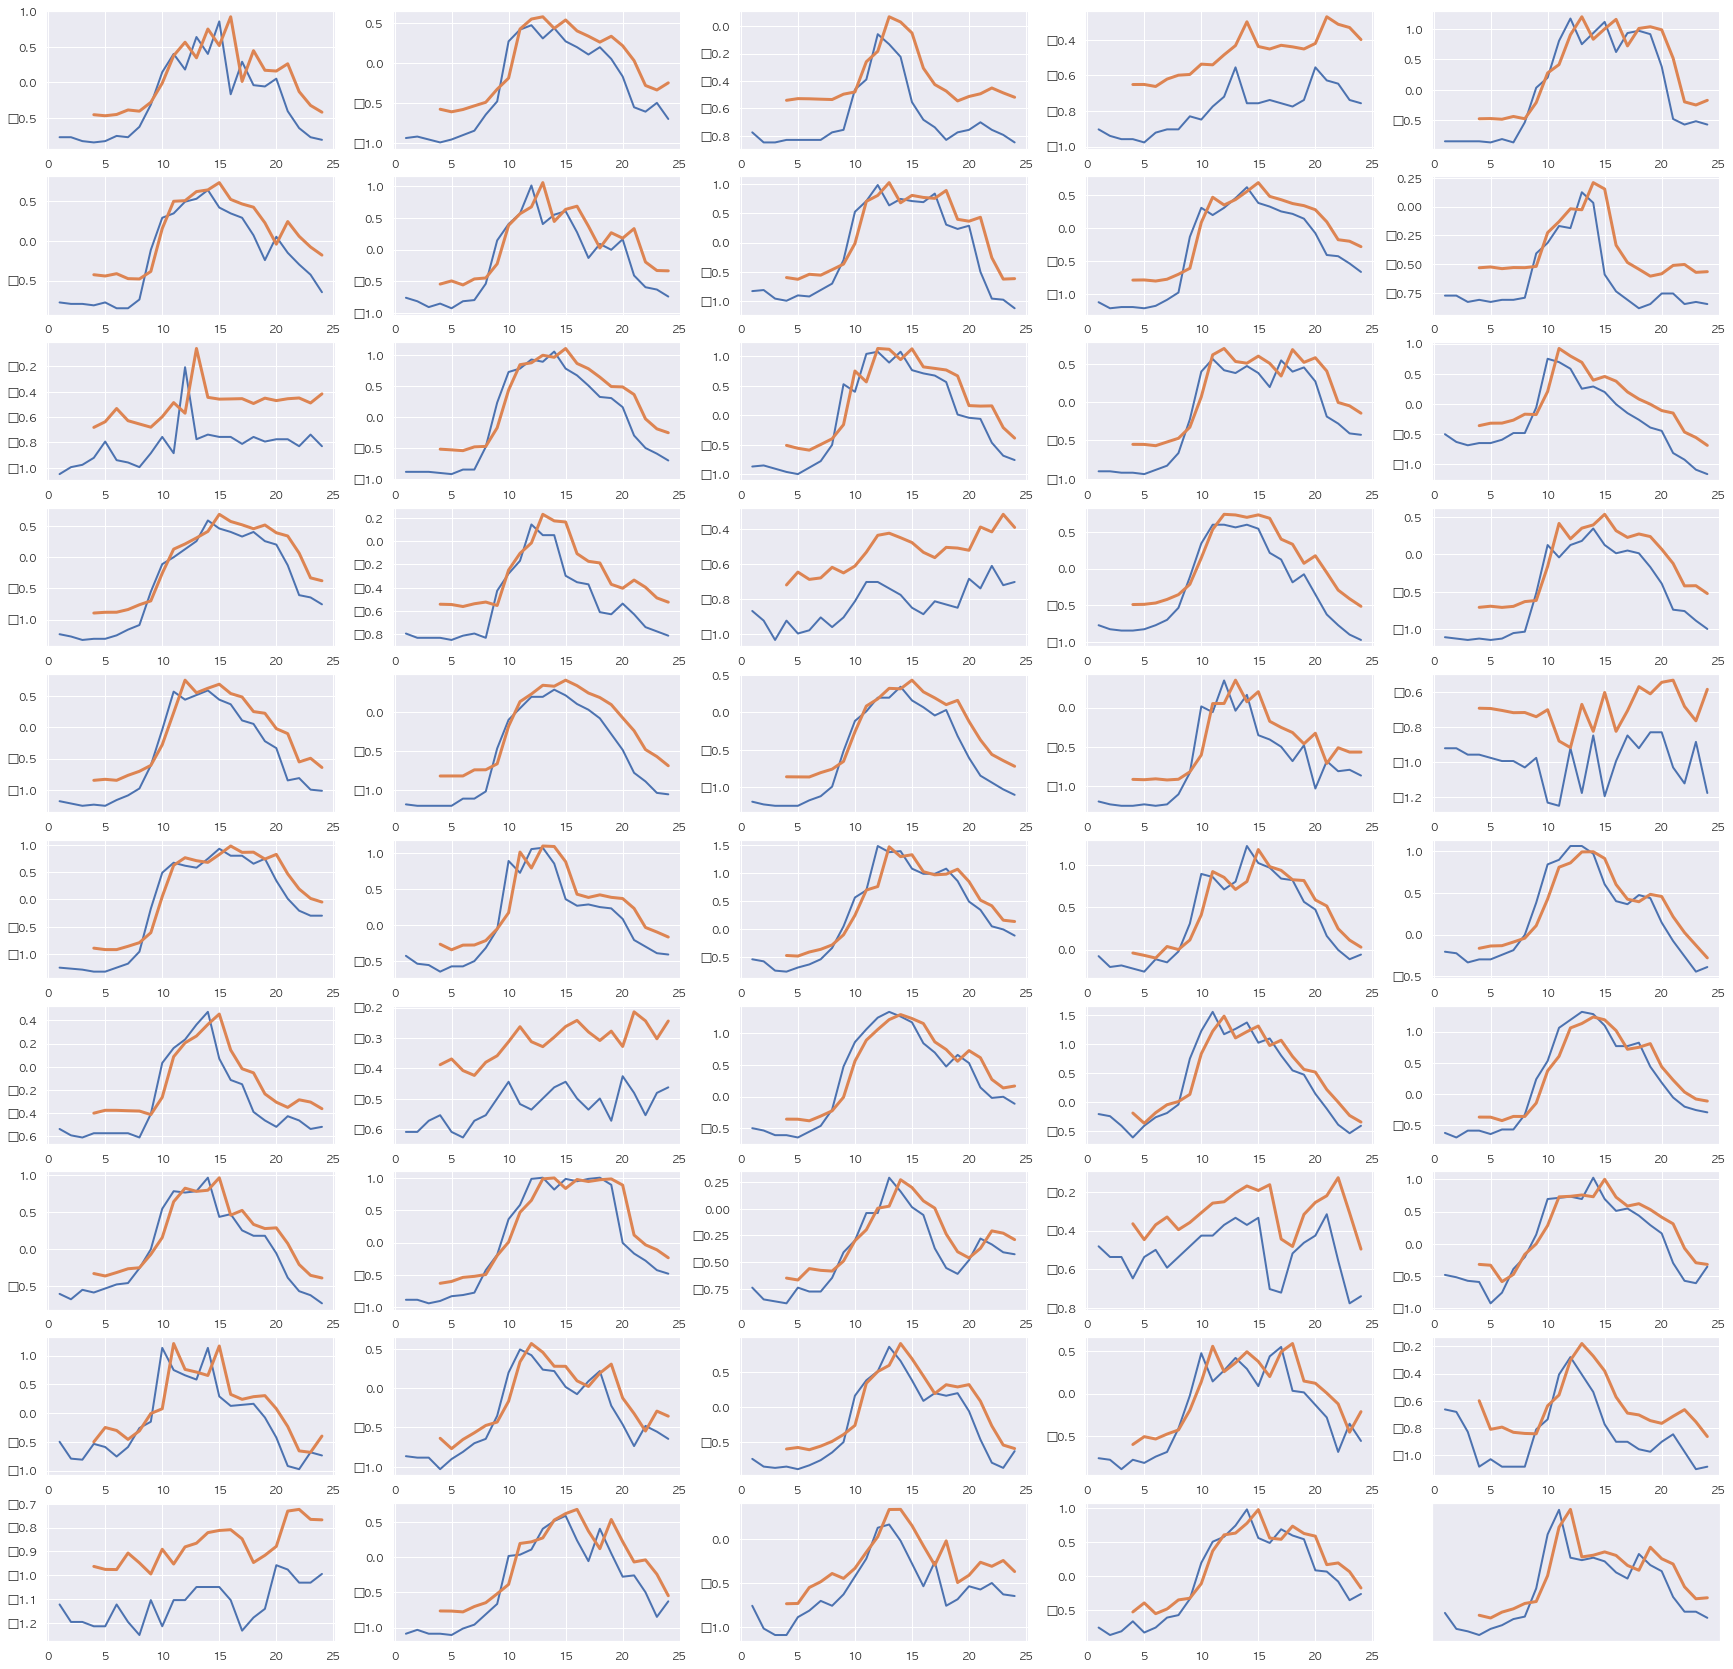

0 multivariate (ta-rhm)


KeyboardInterrupt: 

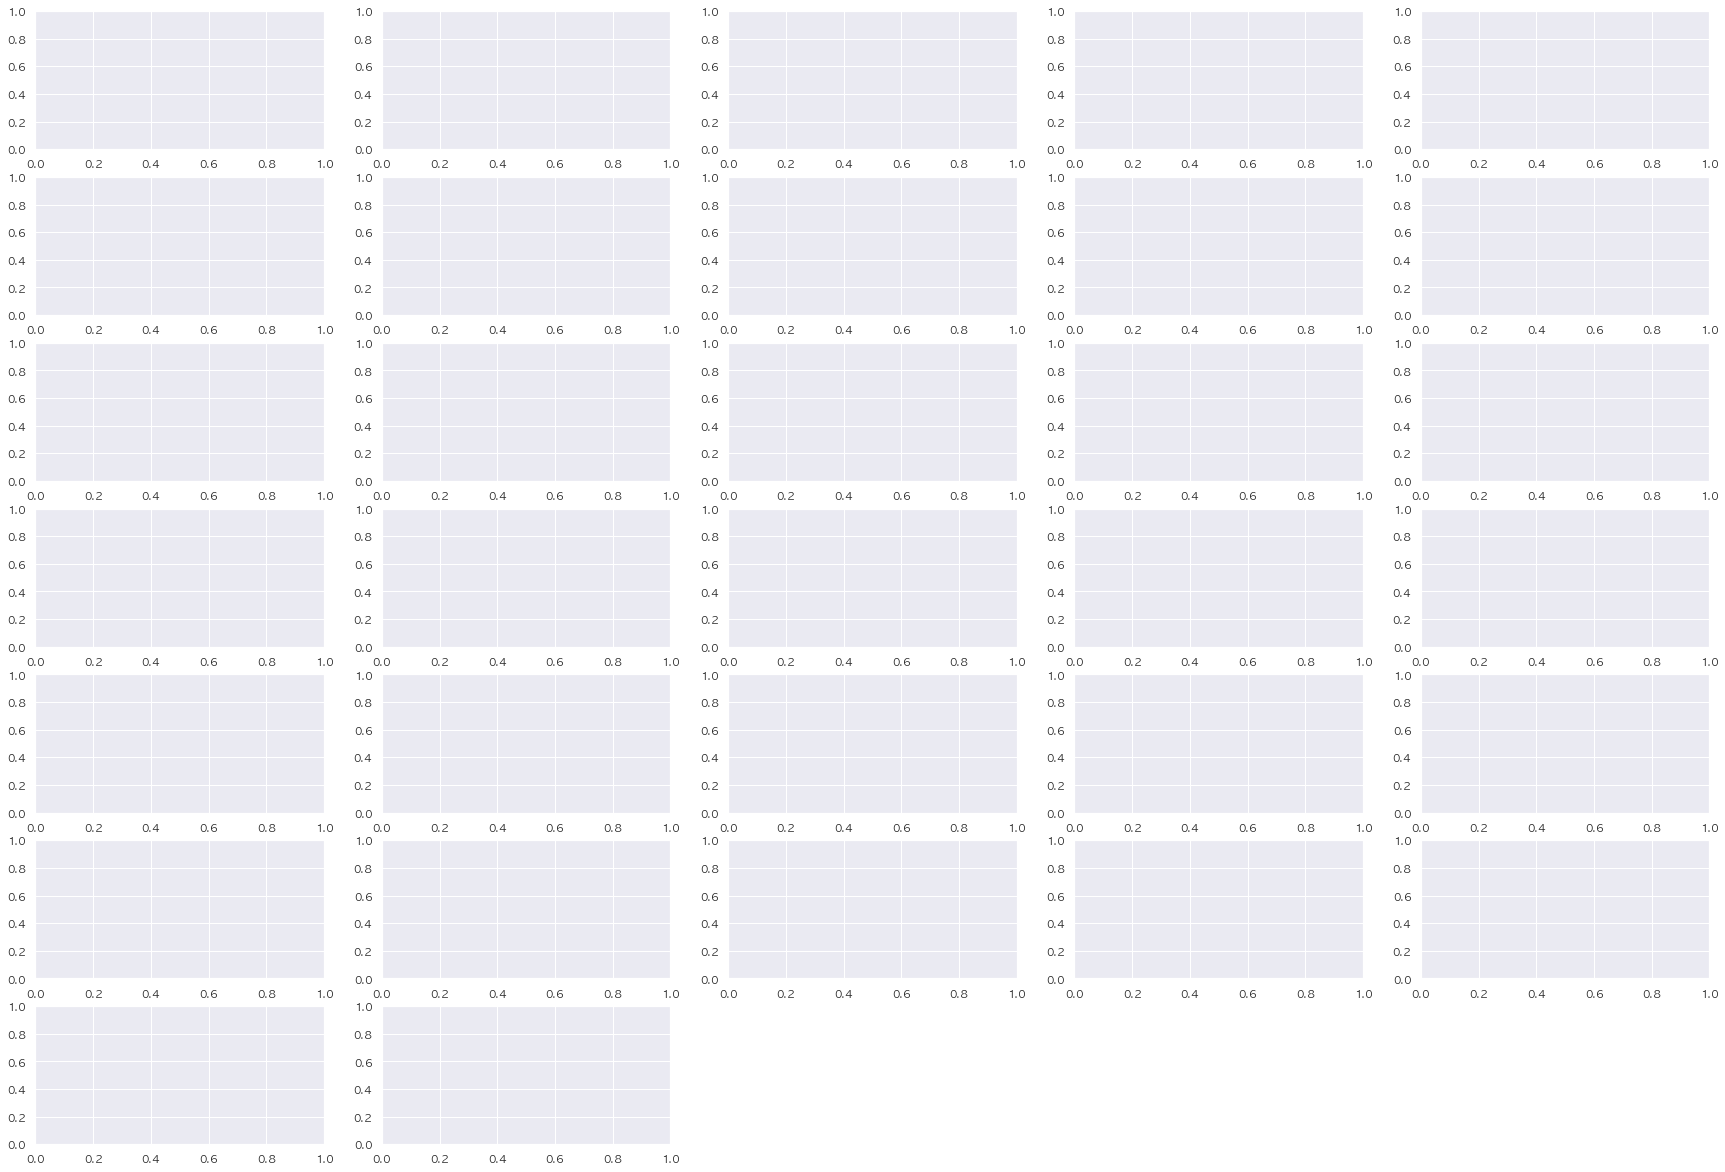

In [21]:
# Visualization
predict_data_length = 3
WINDOW_WIDTH = 3

for _ in range(0, round(len(norm_all_dict['univariate']['test']) / 24), 50):
    for key in models.keys():
        test_df = norm_all_dict[key]['test'][_ * 24:(_ + 50) * 24]
        feature_length = len(test_df.columns)
        print(_ , key)
        cur_model = models[key]

#         if "season" in key:
#             fig, axes = plt.subplots(math.ceil(round(len(test_df) / 24) / 5),5, figsize=(30,30))
#             ax = plt.gca()
#             ax.axes.xaxis.set_visible(False)
#             ax.axes.yaxis.set_visible(False)
#             cnt = 0

#             for split in range(0, round(len(test_df)), 24):
#                 h_key = "{} hours".format(WINDOW_WIDTH)

#                 original_x_labels = [idx for idx in range(1,25)]
#                 predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
#                 original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

#                 date = test_df[split:(split + 24)].index[0]
#                 season = get_season(date.month)

#                 predicts = []
#                 inputs = []

#                 for idx in range(0, (24 - predict_data_length)):
#                     inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
#                     inputs = inputs.reshape(-1, predict_data_length, feature_length)
#                     result = cur_model[season][h_key](inputs).numpy().flatten()[2]

#                     predicts.append(result)
#                     inputs = np.append(inputs.flatten()[1:predict_data_length],result)

#                 sns.lineplot(original_x_labels, original, lw=2, ax=axes[
#                     math.floor(cnt / 5)
#                 ][math.floor(cnt % 5)])
#                 sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
#                     math.floor(cnt / 5)
#                 ][math.floor(cnt % 5)])

#                 cnt += 1
#         else:
        fig, axes = plt.subplots(math.ceil(round(len(test_df) / 24) / 5),5, figsize=(30,30))
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        cnt = 0

        for split in range(0, round(len(test_df)), 24):
            h_key = "{} hours".format(WINDOW_WIDTH)

            original_x_labels = [idx for idx in range(1,25)]
            predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
            original = test_df[split:(split + 24)]['energy (kw 15min)'].values.flatten()

            predicts = []
            inputs = []

            for idx in range(0, (24 - predict_data_length)):
                inputs = test_df[split:(split + 24)].values[idx:predict_data_length + idx].flatten()
                inputs = inputs.reshape(-1, predict_data_length, feature_length)
                result = cur_model[h_key](inputs).numpy().flatten()[2]

                predicts.append(result)
                inputs = np.append(inputs.flatten()[1:predict_data_length],result)

            sns.lineplot(original_x_labels, original, lw=2, ax=axes[
                math.floor(cnt / 5)
            ][math.floor(cnt % 5)])
            sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
                math.floor(cnt / 5)
            ][math.floor(cnt % 5)])

            cnt += 1
        plt.show()